In [40]:
# Near-Inertial Oscillations forced by a summer wind enhanced by the local sea-breeze.
# Section 3.4 Sea-breeze Simulation
# Claudio Iturra, 2024

In [1]:
# IMPORT MODULES
import numpy as np  # http://www.numpy.org
import matplotlib.pyplot as plt   # http://matplotlib.org

In [2]:
whos

Variable   Type      Data/Info
------------------------------
np         module    <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt        module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>


In [3]:
# module constants
g = 9.81
earth_radius = 6.3e6 #(meters)
omega = 0.000072792
rho = 1.25

In [4]:
whos

Variable       Type      Data/Info
----------------------------------
earth_radius   float     6300000.0
g              float     9.81
np             module    <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
omega          float     7.2792e-05
plt            module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
rho            float     1.25


In [5]:
class integration:
    """ a object that contains different methods for the integration of a 2D model"""
    
    def __init__(self,dt,tmax_h,corrector_step=False,scheme="rk4"):
        """ 
        define the setup of the integration
        
        Parameters
        ----------
        dt : float
           time step for the integration scheme
        tmax_h : float
            maximum integration time in hours
        corrector_step : bool 
            use a corrector step in the integration scheme (default False)
        scheme : str
            chose a integration scheme, either "rk4" or "euler" (default euler)
        
        """
        
        self.dt = dt
        self.tmax_h = tmax_h
        self.corrector_step = corrector_step
        self.int_scheme = eval("self."+scheme)
        
        self.iters = int(tmax_h * 3600/dt) 
        self.time = np.arange(0,tmax_h * 3600,dt)
        self.u,self.v = np.zeros(self.iters), np.zeros(self.iters)

    def euler(self,x_start,y_start,f,*args):
        """ 
        euler forward method
        
        Parameters
        ----------
        x_start, y_start :  float
            starting values for the integration scheme
        f : function
            function that is used to integrate the x and y values
        *args: list of arguments for f
            arguments of the used function
        """
        dxdt, dydt = f(*args) 
        
        retx = x_start + dxdt*self.dt
        rety = y_start + dydt*self.dt
        
        return retx, rety
    
    
    def rk4(self,x_start,y_start,f,*args):
        """
        runge-kutta 4 method
        
        Parameters
        ----------
        x_start, y_start :  float
            starting values for the integration scheme
        f : function
            function that is used to integrate the x and y values
        *args: list of arguments for f
            arguments of the used function
        """
        
        h = self.dt
        

        k11,k12 = f(args[0],
                    args[1], 
                    args[2],
                    args[3],args[4])
        
        k21,k22 = f(args[0] + h/2., 
                    args[1] + h/2. * k11, 
                    args[2] + h/2. * k12,
                    args[3],args[4])
        
        k31,k32 = f(args[0] + h/2.,
                    args[1] + h/2. * k21, 
                    args[2] + h/2. * k22,
                    args[3],args[4])
        
        k41,k42 = f(args[0] + h,
                    args[1] + h * k31, 
                    args[2] + h * k32,
                    args[3],args[4])
        
        retx = x_start + h/6. * ( k11 + 2.*k21 + 2.*k31 + k41)
        rety = y_start + h/6. * ( k12 + 2.*k22 + 2.*k32 + k42)
        
        return retx, rety
    
    def integrate2D(self,f,ug,vg,u_init=0.,v_init=0.):
        """ 
        scheme to integrate a 2-dimensional ODE
        (note that the integration scheme is already chosen at this point)
        
        Parameters
        ----------
        f: function
            function to use for the integration
        u_init, v_init:  float
            initial values
        """
        
        self.u[0] = u_init
        self.v[0] = v_init
        
        for t in range(self.iters-1): 
            self.u[t+1], self.v[t+1] = self.int_scheme(self.u[t], self.v[t], \
                  f ,  self.time[t],self.u[t],self.v[t], ug[t], vg[t])
            
            
            if  self.corrector_step:
                self.u[t+1],self.v[t+1] = self.int_scheme(self.u[t], self.v[t],\
                      f ,  self.time[t],self.u[t+1],self.v[t+1],ug[t],vg[t])



In [6]:
whos

Variable       Type      Data/Info
----------------------------------
earth_radius   float     6300000.0
g              float     9.81
integration    type      <class '__main__.integration'>
np             module    <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
omega          float     7.2792e-05
plt            module    <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
rho            float     1.25


In [24]:
class seaBreezeModel:
    """ A simple Sea breeze model"""
    
    def __init__(self,lat,A,phase,gamma,dpdx_synop,dpdy_synop):
        """ set the parameters of the model"""
        
        # parameters
        self.phase = phase # phase of surface pressure gradient in time
        self.A = A         # parameters
        self.lat = lat     # latitude near the CS (Carriel-sur) weather station
        self.gamma = gamma # damping coeeficent
        
       
                
        # infered parameters
        self.latRad = self.lat * np.pi/180
        self.fcor = 2 * omega *  np.sin(self.latRad)  # Coriolis parameter
        
        self.vg = 1./(rho *self.fcor)* dpdx_synop
        self.ug = -1./(rho *self.fcor) * dpdy_synop        
        
        self.C1= - A / ( self.fcor * rho ) * ( ( omega**2 / ( self.fcor**2 - omega**2 ) ) + 1)
        self.C3 = self.A * omega / (rho * ( self.fcor**2 - omega**2 ) )
        
    
    # idealised sea breeze model
    def fIdeal(self,t,u,v,*arg):
        """evoltuiion equation for the sea breeze model in an ideal case without 
        friction, geostrophic wind and the tan(lat) term"""
        return self.fuIdeal(t,u,v), self.fvIdeal(t,u,v)
    
    def fuIdeal(self,t,u,v):
        """evolution equation for the x-component"""
        return self.fcor*v - (self.A/rho)* np.cos((omega*t)+self.phase) 

    def fvIdeal(self,t,u,v):
        """evolution equation for the y-component"""
        return -self.fcor * u
    
    
    # more sophisticated sea breeze model
    def f(self,t,u,v,ug,vg):
        """evoltuiion equation for the sea breeze model"""
        return self.fu(t,u,v,vg), self.fv(t,u,v,ug)
    
    def fu(self,t,u,v,vg):
        """evolution equation for the x-component"""
        return  self.fcor*(v-vg) \
                - (self.A/rho)* np.cos((omega*t)+self.phase) \
                - self.gamma * u \
                + u*v*np.tan(self.latRad)/earth_radius 
     

    def fv(self,t,u,v,ug):
        """evolution equation for the y-component"""
        return - self.fcor * (u -ug) \
               - self.gamma * v \
               - u**2 * np.tan(self.latRad)/earth_radius 
    
class integration:
    """ a object that contains different methods for the integration of a 2D model"""
    
    def __init__(self,dt,tmax_h,corrector_step=False,scheme="rk4"):
        """ 
        define the setup of the integration
        
        Parameters
        ----------
        dt : float
           time step for the integration scheme
        tmax_h : float
            maximum integration time in hours
        corrector_step : bool 
            use a corrector step in the integration scheme (default False)
        scheme : str
            chose a integration scheme, either "rk4" or "euler" (default euler)
        
        """
        
        self.dt = dt
        self.tmax_h = tmax_h
        self.corrector_step = corrector_step
        self.int_scheme = eval("self."+scheme)
        
        self.iters = int(tmax_h * 3600/dt) 
        self.time = np.arange(0,tmax_h * 3600,dt)
        self.u,self.v = np.zeros(self.iters), np.zeros(self.iters)

    def euler(self,x_start,y_start,f,*args):
        """ 
        euler forward method
        
        Parameters
        ----------
        x_start, y_start :  float
            starting values for the integration scheme
        f : function
            function that is used to integrate the x and y values
        *args: list of arguments for f
            arguments of the used function
        """
        dxdt, dydt = f(*args) 
        
        retx = x_start + dxdt*self.dt
        rety = y_start + dydt*self.dt
        
        return retx, rety
    
    
    def rk4(self,x_start,y_start,f,*args):
        """
        runge-kutta 4 method
        
        Parameters
        ----------
        x_start, y_start :  float
            starting values for the integration scheme
        f : function
            function that is used to integrate the x and y values
        *args: list of arguments for f
            arguments of the used function
        """
        
        h = self.dt
        

        k11,k12 = f(args[0],
                    args[1], 
                    args[2],
                    args[3],args[4])
        
        k21,k22 = f(args[0] + h/2., 
                    args[1] + h/2. * k11, 
                    args[2] + h/2. * k12,
                    args[3],args[4])
        
        k31,k32 = f(args[0] + h/2.,
                    args[1] + h/2. * k21, 
                    args[2] + h/2. * k22,
                    args[3],args[4])
        
        k41,k42 = f(args[0] + h,
                    args[1] + h * k31, 
                    args[2] + h * k32,
                    args[3],args[4])
        
        retx = x_start + h/6. * ( k11 + 2.*k21 + 2.*k31 + k41)
        rety = y_start + h/6. * ( k12 + 2.*k22 + 2.*k32 + k42)
        
        return retx, rety
    
    def integrate2D(self,f,ug,vg,u_init=0.,v_init=0.):
        """ 
        scheme to integrate a 2-dimensional ODE
        (note that the integration scheme is already chosen at this point)
        
        Parameters
        ----------
        f: function
            function to use for the integration
        u_init, v_init:  float
            initial values
        """
        
        self.u[0] = u_init
        self.v[0] = v_init
        
        for t in range(self.iters-1): 
            self.u[t+1], self.v[t+1] = self.int_scheme(self.u[t], self.v[t], \
                  f ,  self.time[t],self.u[t],self.v[t], ug[t], vg[t])
            
            
            if  self.corrector_step:
                self.u[t+1],self.v[t+1] = self.int_scheme(self.u[t], self.v[t],\
                      f ,  self.time[t],self.u[t+1],self.v[t+1],ug[t],vg[t])


#%% =============================================================================
# Main
# =============================================================================
if __name__=="__main__":
    plt.close("all")
    
    # define integration method
    dt = 360.
    tmax_h = 720.
    corrector_step = False
    
    method = "euler"
    # define model
    lat = -36
    A = 0.0001
    phase = 0.
    gamma = 0.

In [25]:
    # euler method
    integrator = integration(dt,tmax_h,corrector_step,method)
    ug,vg = np.zeros(integrator.iters),np.zeros(integrator.iters)
    
    sb = seaBreezeModel(lat,A,phase,gamma,ug,vg)
    integrator.integrate2D(sb.fIdeal,ug,vg)
    u_euler,v_euler,time = integrator.u,integrator.v, integrator.time 

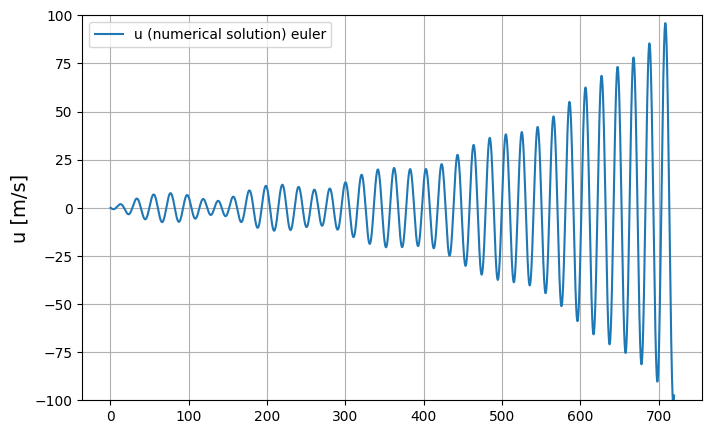

In [28]:
time_axis = time / 3600.
plt.rcParams['figure.figsize'] = [8, 5]

plt.figure()
plt.plot(time_axis, u_euler, label = 'u (numerical solution) euler')
plt.ylabel('u [m/s]', fontsize=14) # label along x-axes
plt.legend()
plt.grid(True)
plt.ylim(-100,100)
#plt.savefig("../img/task1a.png") # save plot as png-file
plt.show() # show plot on screen
    

In [30]:
# matsuno method
corrector_step = True
integrator = integration(dt,tmax_h,corrector_step,method)
integrator.integrate2D(sb.fIdeal,ug, vg)
u_matsuno,v_matsuno,time = integrator.u,integrator.v, integrator.time 

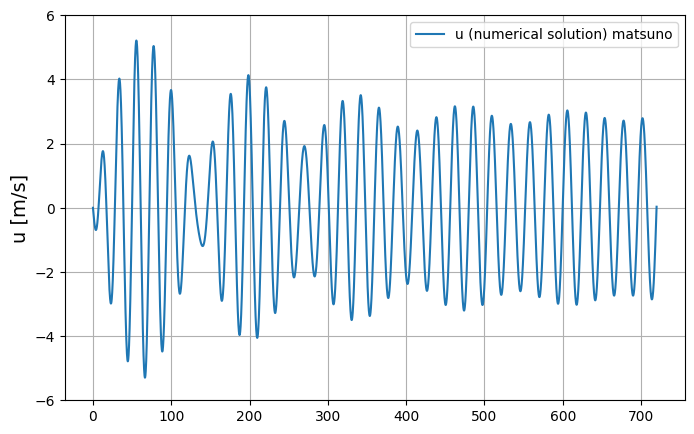

In [33]:
time_axis = time / 3600.
plt.rcParams['figure.figsize'] = [8, 5]

plt.figure()
plt.plot(time_axis, u_matsuno, label = 'u (numerical solution) matsuno')
plt.ylabel('u [m/s]', fontsize=14) # label along x-axes
plt.legend()
plt.grid(True)
plt.ylim(-6,6)
#plt.savefig("../img/task1a.png") # save plot as png-file
plt.show() # show plot on screen

In [34]:
# rk4 method
corrector_step = False
method = "rk4"
    
integrator = integration(dt,tmax_h,corrector_step,method)
integrator.integrate2D(sb.fIdeal,ug,vg)
u_rk4,v_rk4,time = integrator.u,integrator.v, integrator.time 
        

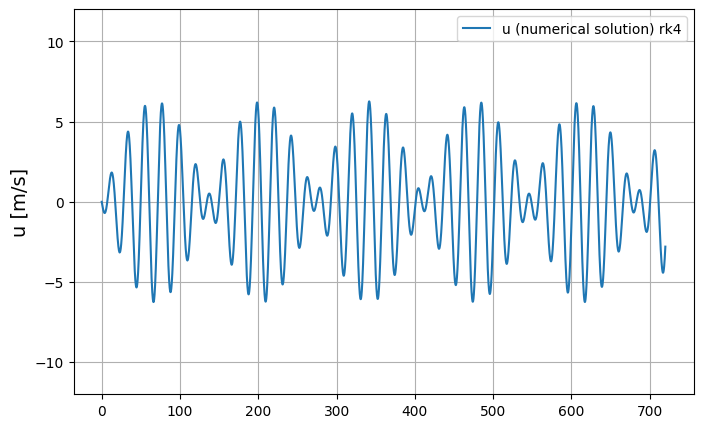

In [36]:
time_axis = time / 3600.
plt.rcParams['figure.figsize'] = [8, 5]

plt.figure()
plt.plot(time_axis, u_rk4, label = 'u (numerical solution) rk4')
plt.ylabel('u [m/s]', fontsize=14) # label along x-axes
plt.legend()
plt.grid(True)
plt.ylim(-12,12)
#plt.savefig("../img/task1a.png") # save plot as png-file
plt.show() # show plot on screen

In [37]:
# Analytical solution
u_ana = np.zeros((integrator.iters)) # analytical solution x-component velocity
u_ana = sb.C1 * np.sin(sb.fcor * time) +  sb.C3 * np.sin((omega * time) + sb.phase)
    
v_ana = np.zeros((integrator.iters)) # analytical solution y-component velocity
v_ana = sb.C1 * np.cos(sb.fcor * time) +  sb.C3 * np.cos((omega * time) + sb.phase)*sb.fcor/omega

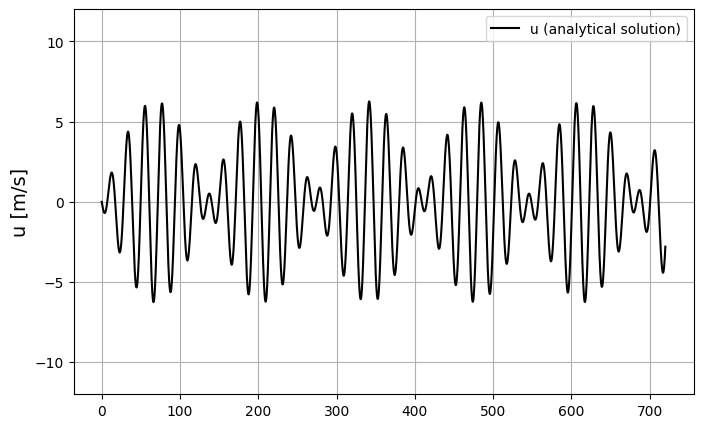

In [39]:
time_axis = time / 3600.
plt.rcParams['figure.figsize'] = [8, 5]

plt.figure()
plt.plot(time_axis, u_ana, 'k-', label = 'u (analytical solution)')
plt.ylabel('u [m/s]', fontsize=14) # label along x-axes
plt.legend()
plt.grid(True)
plt.ylim(-12,12)
#plt.savefig("../img/task1a.png") # save plot as png-file
plt.show() # show plot on screen